In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))

from change_of_parameters import omega_CDM_to_luisa, F_H, F_H_prime
from constants import LAMBDA, L, OMEGA_R_0, KAPPA

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps,solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time

In [2]:
def get_odes(a, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * a**(-4)
    rho_m = rho_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    #s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar],model))     
    # To integrate in a
    s =  - 3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / (a * F_H_prime(Hubble, [LAMBDA, L, b, L_bar],model))     
    # To integrate in log(a)
    #s =  - 3 * KAPPA  * (rho_tot + p_tot/c_light_km**2) / (F_H_prime(Hubble, [LAMBDA, L, b, L_bar],model))     

    #print(s)
    return s


def integrator_GILA(physical_params, model, num_a_points=int(10e5),
                initial_a=1, final_a=0.001,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    L_bar, b, H0 = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    a_int = np.linspace(initial_a, final_a, num_a_points)
    #a_int = np.logspace(np.log10(initial_a), np.log10(final_a), num_a_points)

    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    sol = solve_ivp(system_equations, (initial_a,final_a),
                    [H0], t_eval=a_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_a_points, 'Something is wrong with the integration!'
    assert np.all(a_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    a_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return a_final, Hs_final

In [3]:
discard=0
thin=1

os.chdir(path_data)
print(path_data)

samples_lcdm = emcee.backends.HDFBackend(os.path.join('sample_LCDM_PPS_CC_3params', 'sample_LCDM_PPS_CC_3params.h5'))
samples_beta = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_BETA_PPS_CC_3params', 'sample_BETA_PPS_CC_3params.h5'))
samples_gila = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_GILA_PPS_CC_3params', 'sample_GILA_PPS_CC_3params.h5'))

#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)

/home/matias/Documents/Repos/GILA-output/paper


In [4]:
omega_r = 2.47e-5 
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

#a = np.linspace(1, 0.1, int(10e3))
a = np.linspace(1, 0.001, int(10e3))
#a = np.logspace(0, -3, int(10e3))



[1.         0.99990009 0.99980018 ... 0.00119982 0.00109991 0.001     ]


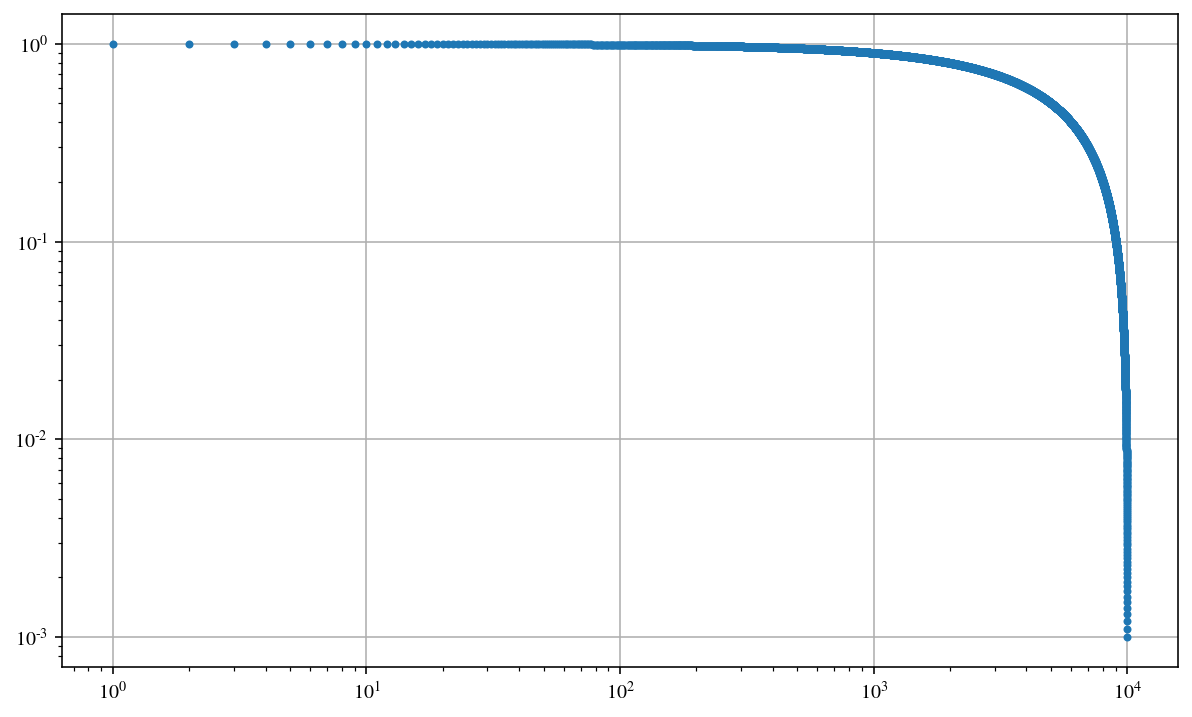

In [5]:
print(a)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(a,'.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = flat_samples_lcdm[:,1]
H0 = flat_samples_lcdm[:,2]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
aou_lcdm = np.zeros(len(H0))

def aou_lcdm_calc(a, H0, Omega_r_lcdm, Omega_m_lcdm, Omega_L_lcdm):
    Hubble = H0 * np.sqrt(Omega_r_lcdm * a**(-4) + Omega_m_lcdm * a**(-3) + Omega_L_lcdm )
    return  - inv_Hub_to_Gyr * simps((a * Hubble)**(-1), a) 

for i in range(len(aou_lcdm)):
    aou_lcdm[i] = aou_lcdm_calc(a, H0[i], Omega_r_lcdm[i], Omega_m_lcdm[i], Omega_L_lcdm[i])

In [7]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = np.mean(flat_samples_lcdm[:,1])
H0 = np.mean(flat_samples_lcdm[:,2])

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
#aou_lcdm = np.zeros(len(H0))

Hubble = H0 * np.sqrt(Omega_r_lcdm * a**(-4) + Omega_m_lcdm * a**(-3) + Omega_L_lcdm )
#plot_hubble_parameter_subplots(a, Hubble, model_name='LCDM')

In [8]:
#BETA MODEL
#M_abs = flat_samples_beta[:,0]
beta = flat_samples_beta[:,1]
H0 = flat_samples_beta[:,2]

aou_beta = np.zeros(1000)

for i in range(len(aou_beta)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        a_final, Hs_final = integrator_GILA(physical_params,model='BETA', num_a_points=int(len(a)),
                                            initial_a=a[0], final_a=a[-1])
        aou_beta[i] = - inv_Hub_to_Gyr * simps((a_final * Hs_final)**(-1), a_final)
    except Exception as e:
        # If integration fails, reject the step
        aou_beta[i] = 0

In [9]:
#GILA MODEL
#M_abs = flat_samples_gila[:,0]
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]

aou_gila = np.zeros(1000)

for i in range(len(aou_gila)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        a_final, Hs_final = integrator_GILA(physical_params,model='GILA', num_a_points=int(len(a)),
                                            initial_a=a[0], final_a=a[-1])
        aou_gila[i] = - inv_Hub_to_Gyr * simps((a_final * Hs_final)**(-1), a_final)    
    except Exception as e:
        # If integration fails, reject the step
        aou_gila[i] = 0

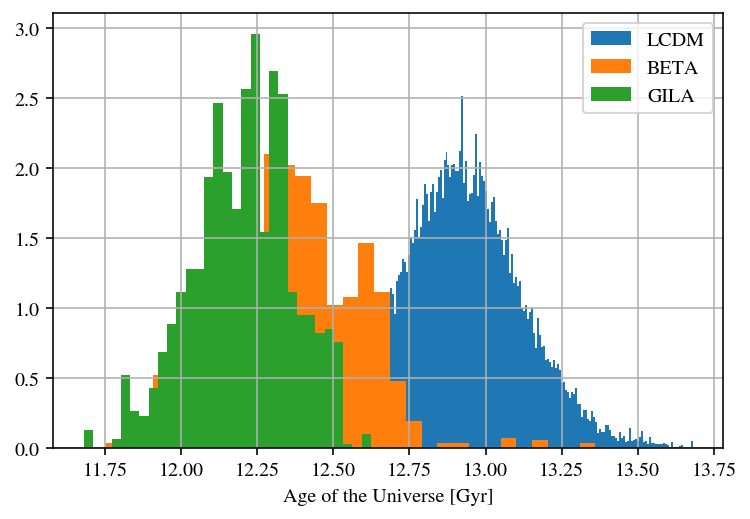

In [10]:
plt.figure()
plt.grid()
plt.hist(aou_lcdm, bins=int(np.sqrt(len(aou_lcdm))), density=True, alpha=1)
plt.hist(aou_beta, bins=int(np.sqrt(len(aou_beta))), density=True, alpha=1)
plt.hist(aou_gila, bins=int(np.sqrt(len(aou_gila))), density=True, alpha=1)
plt.legend(['LCDM','BETA','GILA'])
plt.xlabel('Age of the Universe [Gyr]')

os.chdir(path_figures)
plt.savefig('AOU_{}.pdf'.format(L_bar))